## Tide Table for Cape Lookout

In [1]:
# Imports
import requests as req
import datetime
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Get today's date
today = datetime.date.today()
query_date = str(today).replace('-', '')

In [3]:
# Get the data
url = "https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={}&end_date={}&station=8656841&product=predictions&datum=MLLW&time_zone=lst&units=english&format=json".format(query_date, query_date)
noaa_response = req.get(url)  # Response object 
data = noaa_response.json()  # To json 

for prediction in data['predictions'][0:10]:
    print(prediction)

{'t': '2019-09-02 00:00', 'v': '2.095'}
{'t': '2019-09-02 00:06', 'v': '1.968'}
{'t': '2019-09-02 00:12', 'v': '1.841'}
{'t': '2019-09-02 00:18', 'v': '1.714'}
{'t': '2019-09-02 00:24', 'v': '1.588'}
{'t': '2019-09-02 00:30', 'v': '1.463'}
{'t': '2019-09-02 00:36', 'v': '1.339'}
{'t': '2019-09-02 00:42', 'v': '1.218'}
{'t': '2019-09-02 00:48', 'v': '1.098'}
{'t': '2019-09-02 00:54', 'v': '0.981'}


In [4]:
# Create Pandas DataFrame
tide_predictions = pd.DataFrame.from_dict(data['predictions'])
tide_predictions.head()

,t,v
0,2019-09-02 00:00,2.095
1,2019-09-02 00:06,1.968
2,2019-09-02 00:12,1.841
3,2019-09-02 00:18,1.714
4,2019-09-02 00:24,1.588


In [5]:
tide_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
t    240 non-null object
v    240 non-null object
dtypes: object(2)
memory usage: 3.8+ KB


In [6]:
# Rename columns and change data types 
tide_predictions.columns = ['Hour', 'Height']
tide_predictions['Hour']=tide_predictions['Hour'].str[-5:-3].astype(int) + (tide_predictions['Hour'].str[-2:].astype(int))/60
tide_predictions['Height']=tide_predictions['Height'].astype(float)
tide_predictions.sort_values('Hour')
tide_predictions.head()

,Hour,Height
0,0.0,2.095
1,0.1,1.968
2,0.2,1.841
3,0.3,1.714
4,0.4,1.588


In [7]:
tide_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
Hour      240 non-null float64
Height    240 non-null float64
dtypes: float64(2)
memory usage: 3.8 KB


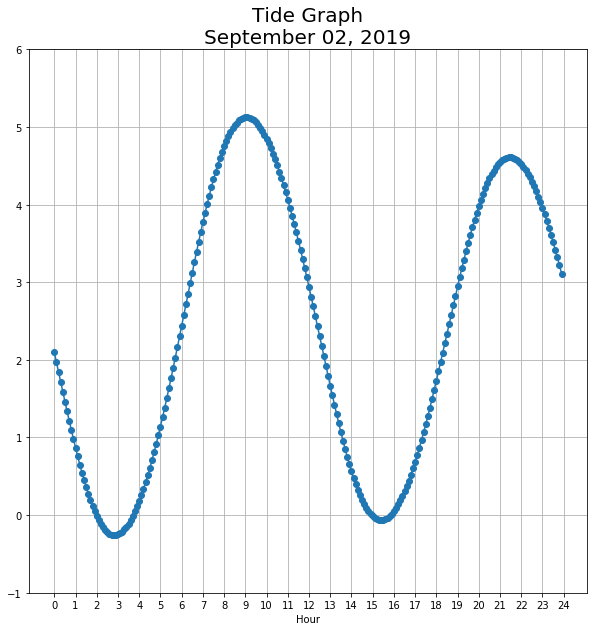

In [8]:
%matplotlib inline 
plt.figure(figsize=(10, 10))
plt.plot(tide_predictions['Hour'], tide_predictions['Height'], marker='o')
plt.ylim(-1, 6)
plt.title("Tide Graph\n{:%B %d, %Y}".format(today), fontsize=20)
plt.grid(axis='both')
plt.xticks(range(0, 25))
plt.xlabel('Hour')
plt.show()

In [9]:
# Calculate times for high and low tides. 

def max_tide(series):
    """Returns list of indices for which 'height' is a relative maximum."""
    maxima = []
    for i in range(238):
        if series.iloc[i] <= series.iloc[i+1] and series.iloc[i+1] >= series.iloc[i+2]:
            maxima.append(i+1)
    return maxima
        
            
def min_tide(series):
    """Returns list of indices for which 'height' is a relative minimum."""
    minima = []
    for i in range(238):
        if series.iloc[i] >= series.iloc[i+1] and series.iloc[i+1] <= series.iloc[i+2]:
            minima.append(i+1) 
    return minima


def hour_to_time(hpm):
    """Converts 'hours past midnight' to 'time of day'."""
    h = int(hpm)
    m = int(round((hpm - h) * 60, 0))
    
    if h == 0 or h == 12:
        hour = '12' 
    else:
        hour = str(h % 12)
        
    if m < 10:
        minute = '0' + str(m)
    else: 
        minute = str(m)
        
    if h < 12:
        meridiam = 'AM'
    else:
        meridiam = 'PM'
        
    return  hour + ':' + minute + ' ' + meridiam


maxima = max_tide(tide_predictions['Height'])
minima = min_tide(tide_predictions['Height'])

high_tide = tide_predictions.iloc[maxima].copy()
high_tide.loc[:, 'Event'] = 'High Tide'

low_tide = tide_predictions.iloc[minima].copy() 
low_tide.loc[:, 'Event'] = 'Low Tide'

tide_table = pd.concat([high_tide, low_tide], ignore_index=True)

tide_table['Time'] = tide_table['Hour'].apply(hour_to_time)
tide_table = tide_table[['Time', 'Hour', 'Height', 'Event']]
tide_table.sort_values('Hour', inplace=True)
tide_table.index = list(range(len(tide_table)))
tide_table

,Time,Hour,Height,Event
0,2:48 AM,2.8,-0.257,Low Tide
1,9:00 AM,9.0,5.122,High Tide
2,9:06 AM,9.1,5.122,High Tide
3,3:24 PM,15.4,-0.063,Low Tide
4,9:24 PM,21.4,4.607,High Tide
